In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Часть 1. Игрушечный набор данных "девушка в баре"

Цель – "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.

Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.

### Создание набора данных

In [2]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

#### Обучающая выборка

In [4]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,0,1,1,0,1,0,0,0,1
1,1,0,1,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,1,0,0,1
5,0,1,0,1,0,1,0,0,0,1
6,0,0,1,1,0,0,0,1,0,1


#### Тестовая выборка

In [5]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0
2,1,0,1,0,0,1,0,1


In [6]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много,Уровень_красноречия_высокий,Алкоголь_в_напитке_да,Внешность_отталкивающая,Алкоголь_в_напитке_нет,Внешность_приятная
0,0,0,1,1,1,0,0,1
1,0,1,0,0,1,0,0,1
2,1,0,1,0,0,0,1,1
3,1,1,0,0,0,1,1,0
4,0,0,1,0,1,1,0,0
5,0,0,1,1,1,1,0,0
6,1,0,1,0,1,0,0,1


In [7]:
df_test

,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много,Уровень_красноречия_высокий,Алкоголь_в_напитке_да,Внешность_отталкивающая,Алкоголь_в_напитке_нет,Внешность_приятная
0,1,0,1,0,0,0,1,1
1,0,1,0,1,1,0,0,1
2,1,0,1,0,1,1,0,0


### Вопрос 1. Какова энтропия начальной системы (S0)? Под состояниями системы понимаем значения признака "Поедет" – 0 или 1 (то есть всего 2 состояния).

In [8]:
y.value_counts(normalize=True)

0    0.571429
1    0.428571
Name: Поедет, dtype: float64

Посчитаем начальную энтропию

In [9]:
p1 = y.value_counts(normalize=True)[0]
p2 = y.value_counts(normalize=True)[1]

In [10]:
E = -p1*np.log2(p1)-p2*np.log2(p2)
round(E,3)

0.985

### Вопрос 2. Рассмотрим разбиение обучающей выборки по признаку "Внешность_приятная". Какова энтропия S1 левой группы, тех, у кого внешность приятная, и правой группы – S2? Каков прирост информации при данном разбиении (IG)?

In [11]:
df_train['Внешность_приятная']

0    1
1    1
2    1
3    0
4    0
5    0
6    1
Name: Внешность_приятная, dtype: uint8

In [12]:
y

0    0
1    1
2    0
3    1
4    1
5    0
6    0
Name: Поедет, dtype: int64

Если разбить по признаку 'Внешность_приятная' то слева окажется 3 наблюдения а справа 4.

In [13]:
nn = pd.merge(df_train['Внешность_приятная'], y, left_index=True, right_index=True)
nn

,Внешность_приятная,Поедет
0,1,0
1,1,1
2,1,0
3,0,1
4,0,1
5,0,0
6,1,0


Посчитаем для каждого случая энтропию. Если внешность приятная

In [14]:
nn[nn['Внешность_приятная']>0]

,Внешность_приятная,Поедет
0,1,0
1,1,1
2,1,0
6,1,0


In [15]:
nn[nn['Внешность_приятная']<1]

,Внешность_приятная,Поедет
3,0,1
4,0,1
5,0,0


In [16]:
E2 = ((4./7)*((-1./4)*np.log2(1./4)-(3./4)*np.log2(3./4)))+((3./7)*((-2/3.)*np.log2(2/3.)-(1/3.)*np.log2(1/3.)))
E2

0.8571428571428571

In [17]:
IG = E - E2
round(IG,3)

0.128

#### Information Gain равен 0.128

In [18]:
((-1./4)*np.log2(1./4)-(3./4)*np.log2(3./4))

0.8112781244591328

In [19]:
((-2/3.)*np.log2(2/3.)-(1/3.)*np.log2(1/3.))

0.9182958340544896

### Построим с помощью sklearn дерево решений

In [20]:
first_tree = DecisionTreeClassifier(random_state=42)
first_tree.fit(df_train, y)

DecisionTreeClassifier(random_state=42)

функция для расчета точности

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [22]:
def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))

In [23]:
quality_report(first_tree.predict(df_train), y)

Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1_score: 1.000


In [24]:
col = list(df_train.columns.values)
col

['Уровень_красноречия_средний',
 'Потраченные_деньги_мало',
 'Потраченные_деньги_много',
 'Уровень_красноречия_высокий',
 'Алкоголь_в_напитке_да',
 'Внешность_отталкивающая',
 'Алкоголь_в_напитке_нет',
 'Внешность_приятная']

Построим дерево решений

In [25]:
from sklearn.tree import export_graphviz
export_graphviz(first_tree, feature_names=col, 
out_file='s_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 's_tree.dot' -o 's_tree.png'

"dot" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


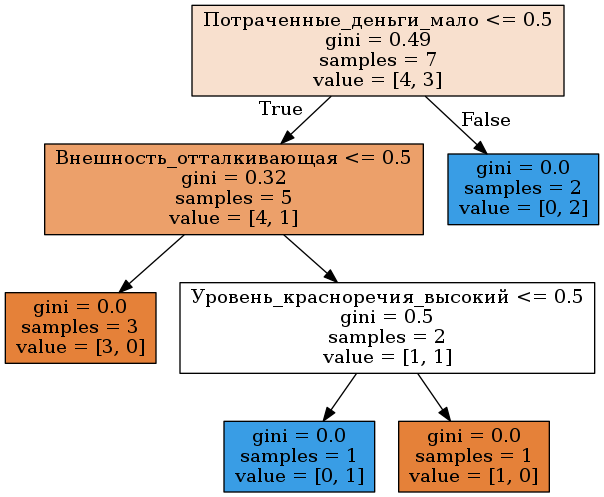

In [26]:
from IPython.display import Image
Image(filename='s_tree.png') 

## Часть 2. Функции для расчета энтропии и прироста информации

Примерчик для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [27]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

In [28]:
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Дальше пусть шарики разбиваются на 2 группы

In [29]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

#### Реализуем функцию для расчета энтропии Шеннона.

In [30]:
def entropy(a_list):
    array_d = {}.fromkeys(a_list, 0)
    for a in a_list:
        array_d[a] += 1
        
    N = float(len(a_list))
    
    array_prob = {}.fromkeys(a_list, 0)
    for value in array_d:
        array_prob[value] = array_d[value]/N
    
    ent_list=[]
    for value in array_prob:
        ent_list.append(array_prob[value]*np.log2(array_prob[value]))
    enropy = -1 * sum(ent_list)
    return enropy
    print(array_prob)
    print(ent_list)
    print('Энтропия равна:', end='')
    print(round(enropy, 3))

### Вопрос 3. Чему равна энтропия состояния, заданного списком balls_left?

In [31]:
entropy(balls_left)

0.9612366047228759

### Вопрос 4. Чему равна энтропия игральной кости с несмещенным центром тяжести?

In [32]:
entropy([1,2,3,4,5,6])

2.584962500721156

### Вопрос 5. Каков прирост информации при разделении выборки на balls_left и balls_right?

In [33]:
# расчет прироста информации

def information_gain(root, left, right):
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    ent_root = entropy(root)
    n = float(len(root))
    l = len(left)
    r = len(right)
    ent_left = entropy(left)
    ent_right = entropy(right)
    ig = ent_root - (l/n * ent_left) - (r/n * ent_right)
    return ig

In [34]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

## Часть 3. Набор данных "Adult"

#### Описание набора:

[Набор данных UCI](https://archive.ics.uci.edu/ml/machine-learning-databases/adult) Adult (качать не надо, все есть в репозитории): классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более $ 50 000 в год.

Описание признаков:

- Age – возраст, количественный признак
- Workclass – тип работодателя, количественный признак
- fnlwgt – итоговый вес обьекта, количественный признак
- Education – уровень образования, качественный признак
- Education_Num – количество лет обучения, количественный признак
- Martial_Status – семейное положение, категориальный признак
- Occupation – профессия, категориальный признак
- Relationship – тип семейных отношений, категориальный признак
- Race – раса, категориальный признак
- Sex – пол, качественный признак
- Capital_Gain – прирост капитала, количественный признак
- Capital_Loss – потери капитала, количественный признак
- Hours_per_week – количество часов работы в неделю, количественный признак
- Country – страна, категориальный признак

Целевая переменная: Target – уровень заработка, категориальный (бинарный) признак

Считываем обучающую и тестовую выборки.

In [35]:
data_train = pd.read_csv('data/adult_train.csv', sep=';') 

In [36]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [37]:
data_test = pd.read_csv('data/adult_test.csv', sep=';') 

In [38]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [39]:
# необходимо убрать строки с неправильными метками в тестовой выборке
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# перекодируем target в числовое поле
data_train.at[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.at[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.at[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.at[data_test['Target'] == ' >50K.', 'Target'] = 1

#### Первичный анализ данных.

In [40]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Взглянем на распределение целевой переменной

In [41]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

#### Проверяем типы данных



In [42]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [43]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

In [44]:
data_test['Age'] = data_test['Age'].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [45]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

#### Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением

In [46]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [47]:
# заполним пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())   

In [48]:
data_train.isnull().sum()

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education_Num        0
Martial_Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_per_week       0
Country            583
Target               0
dtype: int64

#### Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода pandas get_dummies.

In [49]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [50]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [51]:
data_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...
Country_ Thailand,16281.0,0.000737,0.027140,0.0,0.0,0.0,0.0,1.0
Country_ Trinadad&Tobago,16281.0,0.000491,0.022162,0.0,0.0,0.0,0.0,1.0
Country_ United-States,16281.0,0.900559,0.299262,0.0,1.0,1.0,1.0,1.0
Country_ Vietnam,16281.0,0.001167,0.034143,0.0,0.0,0.0,0.0,1.0


In [52]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [53]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

#### В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.

In [54]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [55]:
set(data_train.columns) - set(data_test.columns)

set()

In [56]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [57]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


Разделим целевую переменную с остальными признаками

In [58]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

## 3.1. Дерево решений без настройки параметров

Обучим на имеющейся выборке дерево решений (DecisionTreeClassifier) максимальной глубины 3. Используем параметр random_state = 17 для воспроизводимости результатов.

In [59]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

Сделаем  помощью полученной модели прогноз для тестовой выборки

In [60]:
tree_predictions = tree.predict(X_test)

In [61]:
print("\nTest quality")
quality_report(tree_predictions, y_test)


Test quality
Accuracy: 0.845
Precision: 0.507
Recall: 0.756
f1_score: 0.607


### Вопрос 6. Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

ответ: Accuracy = 0.845

## 3.2. Дерево решений с настройкой параметров

Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier, опять random_state = 17 ). Максимальную глубину настройте на кросс-валидации с помощью GridSearchCV. Проведите 5-кратную кросс-валидацию

In [62]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17), 
                                 tree_params, 
                                 verbose=True, n_jobs=-1, cv=5)                   

locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.8s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(2, 11)}, verbose=True)

In [63]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8562698879315647


#### Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение max_depth в моем случае) и оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.

In [64]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)

### Вопрос 7. Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

In [65]:
print("\nTest quality")
quality_report(tuned_tree_predictions, y_test)


Test quality
Accuracy: 0.847
Precision: 0.540
Recall: 0.743
f1_score: 0.625


## 3.3. Случайный лес без настройки параметров (опционально)

In [66]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=17)

Сделаем с помощью полученной модели прогноз для тестовой выборки.

In [67]:
forest_predictions = rf.predict(X_test)

In [68]:
print(accuracy_score(y_test, forest_predictions))

0.8576254529820035


## 3.4. Случайный лес с настройкой параметров (опционально)

Обучим на имеющейся выборке случайный лес (RandomForestClassifier). Максимальную глубину и максимальное число признаков для каждого дерева настроим с помощью GridSearchCV.

In [69]:
from sklearn.model_selection import RandomizedSearchCV

In [70]:
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 10)}

locally_best_forest = RandomizedSearchCV(RandomForestClassifier(random_state=17),
                                  forest_params, 
                                 verbose=True, cv=5)
locally_best_forest.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 14.2min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=17),
                   param_distributions={'max_depth': range(10, 21),
                                        'max_features': range(5, 105, 10)},
                   verbose=True)

In [71]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_features': 45, 'max_depth': 16}
Best cross validaton score 0.8645928281407324


Прогноз для тестовой выборки

In [72]:
tuned_forest_predictions = locally_best_forest.predict(X_test)

In [73]:
print("\nTest quality")
quality_report(tuned_forest_predictions, y_test)


Test quality
Accuracy: 0.864
Precision: 0.585
Recall: 0.786
f1_score: 0.671


Домашнее задание выполнено 10 из 10

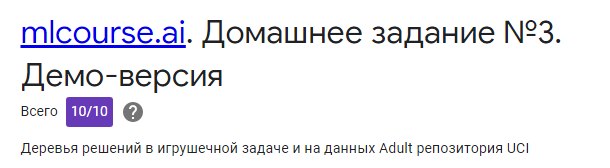